<img src="zona_jobs.png">

# Trabajo Práctico N° 1: Análisis Exploratorio


## 1. Preparación de los datos

### 1.1. Importación de Librerías

In [144]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.mlab import bivariate_normal
%matplotlib inline
import pandas as pd
from dateutil.parser import parse
import numpy as np
import warnings
import datetime as dt
import seaborn as sns
warnings.filterwarnings('ignore')
import plotly
from wordcloud.wordcloud import WordCloud
plotly.tools.set_credentials_file(username='soyarielruiz', api_key='Io0U7KvMLYpCw01a1vNJ')

import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

### 1.2. Carga de Archivos

In [84]:
# Carga de archivos
post_educacion  = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad   = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas          = pd.read_csv('../data/fiuba_3_vistas.csv'       , parse_dates=['timestamp'])
postulaciones   = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online   = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
})

### 1.3. Ajustes de los Archivos antes de procesar

In [85]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)

In [86]:
# Agrupo las áreas parecidas.
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

In [87]:
# Convierto el nombre del area a category.
avisos_detalles['nombre_area'] = avisos_detalles['nombre_area'].astype('category')

In [88]:
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)
post_gen_edad['edad'] = (now - pd.to_datetime(post_gen_edad['fechanacimiento'])).astype('<m8[Y]')

In [89]:
# Renombramos algunas columnas para unificar criterios.
vistas.rename(columns={"idAviso":"idaviso"}     , inplace=True)
vistas.rename(columns={"timestamp":"fechavista"}, inplace=True)

# Cambiar el tipo de dato de la fecha de vista.
vistas[['fechavista']] = vistas[['fechavista']].apply(pd.to_datetime)

### 1.4. Ajustes de los Archivos antes de procesar

#### 1.4.1 Merges necesarios

In [90]:
usuarios_detalle                             = pd.merge(post_educacion                    , post_gen_edad   , how='inner', left_on='idpostulante', right_on='idpostulante')
postulaciones_con_detalle_de_aviso           = pd.merge(postulaciones                     , avisos_detalles , how='inner', left_on='idaviso'     , right_on='idaviso')
postulaciones_con_detalle_de_aviso_y_usuario = pd.merge(postulaciones_con_detalle_de_aviso, usuarios_detalle, how='inner', left_on='idpostulante', right_on='idpostulante')
visitas_con_detalle_de_aviso                 = pd.merge(vistas                            , avisos_detalles , how='inner', left_on='idaviso'     , right_on='idaviso')
visitas_con_detalle_de_aviso_y_usuario       = pd.merge(visitas_con_detalle_de_aviso      , usuarios_detalle, how='inner', left_on='idpostulante', right_on='idpostulante')

#### 1.4.2 Busqueda de Maxima Educación

In [91]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa (la de nivel academico mas alto) de cada postulante.
valores_educacion = pd.DataFrame({
    'nombre': [
        'Otro',  'Otro',  'Otro',  'Secundario',  'Secundario',  'Secundario',  'Terciario/Técnico', 'Universitario',  \
        'Terciario/Técnico', 'Universitario',  'Terciario/Técnico', 'Universitario',  'Posgrado', 'Master','Posgrado', \
        'Master','Posgrado', 'Master','Doctorado','Doctorado','Doctorado'
    ],
    'estado': [
        'Abandonado', 'En Curso','Graduado','Abandonado', 'En Curso','Graduado','Abandonado', 'Abandonado', 'En Curso',\
        'En Curso','Graduado','Graduado','Abandonado', 'Abandonado', 'En Curso','En Curso','Graduado','Graduado',\
        'Abandonado', 'En Curso','Graduado'
    ],
    'valor_educacion': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
})

# Y le pongo las mismas categorias que ya habia encontrado previamente.
valores_educacion.nombre = valores_educacion.nombre.astype((pd.api.types.CategoricalDtype(post_educacion.nombre.cat.categories)))
valores_educacion.estado = valores_educacion.estado.astype((pd.api.types.CategoricalDtype(post_educacion.estado.cat.categories)))

In [92]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion, how='inner', left_on=['nombre','estado'], right_on = ['nombre','estado'])
# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [93]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()
# Controlo cuantas lineas me devolvio.
# max_post_educacion.count()

In [94]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', left_on=['idpostulante','valor_educacion'], right_on = ['idpostulante','valor_educacion'])
# post_educacion.count()

In [95]:
post_educacion_graph = post_educacion.groupby(['nombre', 'estado', 'valor_educacion'])['idpostulante'].count().reset_index()
post_educacion_graph['resumen'] = post_educacion_graph.nombre.astype('object') + ' ' + post_educacion_graph.estado.astype('object')
post_educacion_graph.sort_values('valor_educacion', inplace=True)
post_educacion_graph.reset_index()
post_educacion_graph.drop(['nombre', 'estado', 'valor_educacion'], axis=1, inplace=True)
post_educacion_graph.rename(columns= {'idpostulante' : 'Cantidad de Postulantes'}, inplace=True)

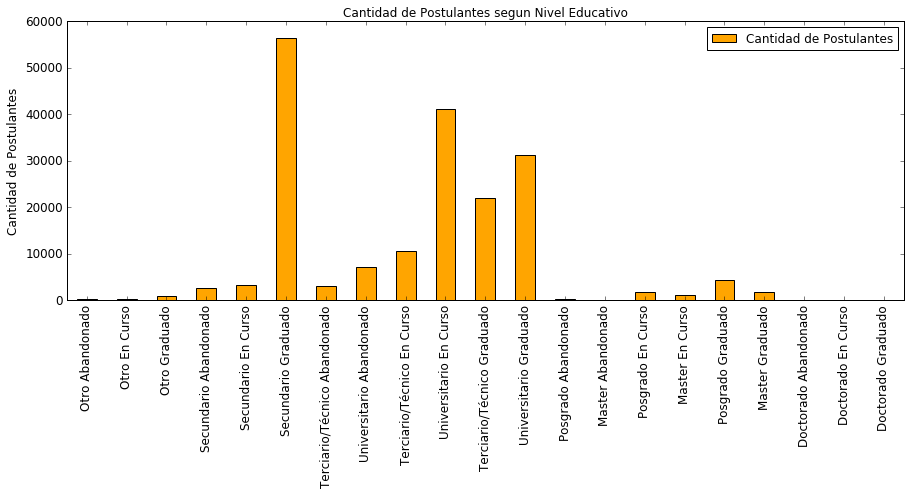

In [96]:
ax = plt.gca()
post_educacion_graph[['resumen','Cantidad de Postulantes']]\
    .plot(ax=ax, kind='bar', x = 'resumen', title ="Cantidad de Postulantes segun Nivel Educativo", figsize=(15, 5), legend=True, fontsize=12, color='orange')

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Cantidad de Postulantes", fontsize=12);

## 2.1. Perfil de Postulantes

In [97]:
# Generamos un perfil sobre el postulante en base a los datos que tenemos, educacion, edad.
postulantes = pd.merge(max_post_educacion, post_gen_edad)
pd.to_datetime(postulantes['fechanacimiento'])
postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
pd.to_numeric(postulantes['edad'])

# Dejo solo los mayores de edad y menores a la edad de jubilacion
postulantes_filtrados_por_edad = postulantes.loc[(postulantes['edad'] >= 18) & (postulantes['edad'] <= 65)].reset_index()
postulantes_filtrados_por_edad.drop('index', inplace=True, axis=1)

postulantes_filtrados_por_edad.head()

,idpostulante,valor_educacion,fechanacimiento,sexo,edad
0,0z5VvGv,6,1987-10-18,MASC,30.0
1,0zB026d,11,1978-02-23,FEM,40.0
2,0zB03O9,9,1987-07-04,FEM,30.0
3,0zB08lq,6,1972-06-09,MASC,45.0
4,0zB0NWY,12,1987-09-20,FEM,30.0


In [98]:
# Creo un nuevo DataFrame de los postulantes y el area para el cual se postulan con mas frecuencia.
postulantes_areas = pd.merge(postulaciones, avisos_detalles, how='inner', on='idaviso')
postulantes_areas = pd.DataFrame(postulantes_areas.groupby(['idpostulante', 'nombre_area'])['idaviso'].count()).reset_index()
postulantes_areas = pd.DataFrame(postulantes_areas.sort_values(['idpostulante','idaviso'], ascending=False))
postulantes_areas = postulantes_areas.groupby(['idpostulante']).first()
postulantes_areas.drop('idaviso', inplace=True, axis=1)
postulantes_areas = postulantes_areas.reset_index()
# postulantes_areas.head(20)

In [99]:
postulantes_filtrados_por_edad.set_index('idpostulante', inplace=True)
postulantes_areas.set_index('idpostulante', inplace=True)

postulantes_filtrados_por_edad.index.name = None
postulantes_areas.index.name = None

In [100]:
postulantes_filtrados_por_edad = pd.concat([postulantes_filtrados_por_edad, postulantes_areas], axis=1)

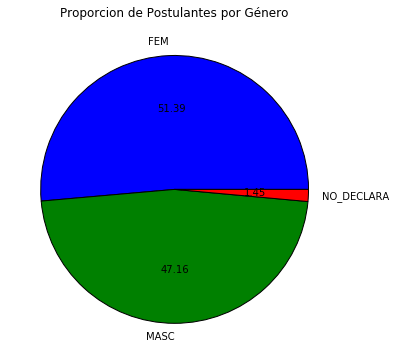

In [101]:
ax = plt.gca()
postulantes_por_genero = postulantes.groupby('sexo')['idpostulante'].count()
postulantes_por_genero.rename({'idpostulante': 'Cantidad de Postulantes'}, inplace=True)
pie = postulantes_por_genero.plot(kind='pie', figsize=(6,6), autopct='%.2f', title="Proporcion de Postulantes por Género")
ax.set_xlabel('');
ax.set_ylabel('');

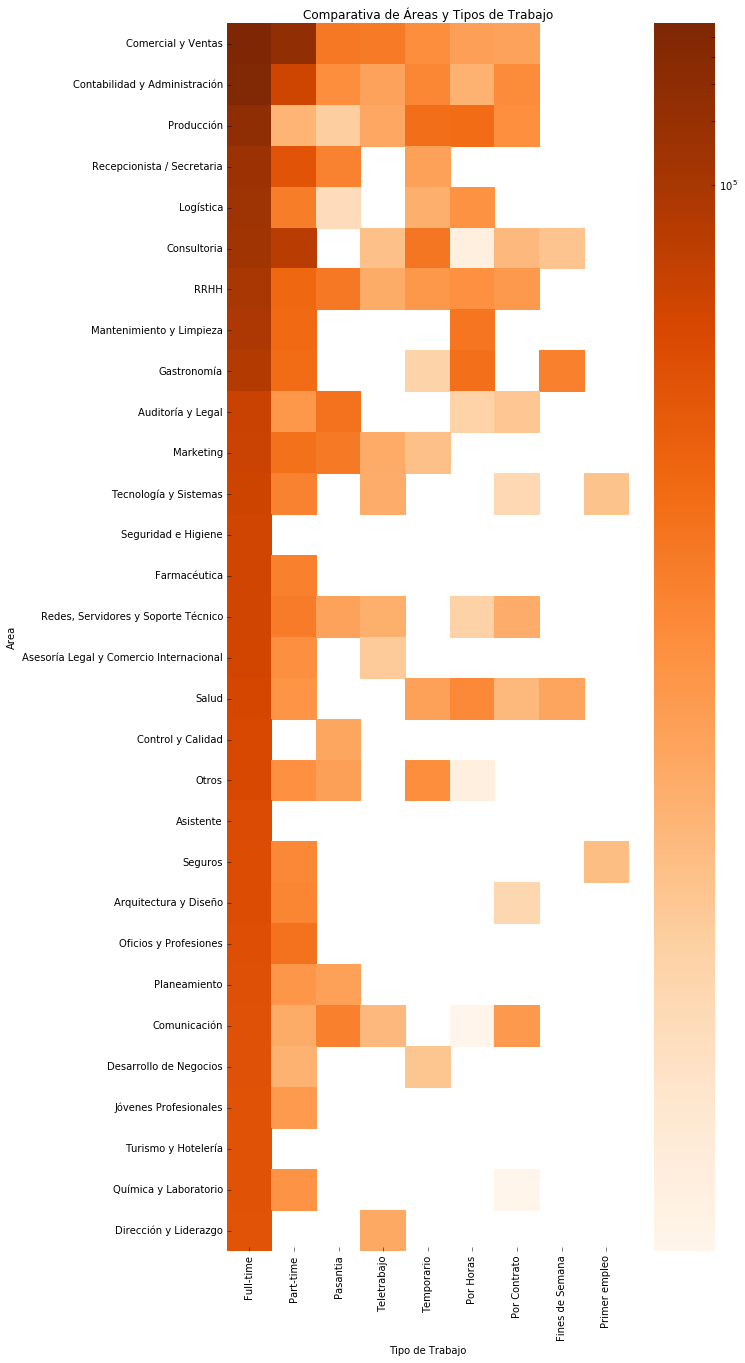

In [102]:
# Creo un nuevo DataFrame de los postulantes y el area para el cual se postulan con mas frecuencia.
postulantes_areas_tipo_trabajo = pd.merge(postulaciones, avisos_detalles, how='inner', on='idaviso')
postulantes_areas_tipo_trabajo = postulantes_areas_tipo_trabajo.groupby(['nombre_area', \
                                                                         'tipo_de_trabajo'])['idpostulante'].count().reset_index()
postulantes_areas_tipo_trabajo = postulantes_areas_tipo_trabajo.sort_values('idpostulante', ascending=False)

postulantes_areas_tipo_trabajo.rename({
    'tipo_de_trabajo': 'Tipo de Trabajo',
    'nombre_area': 'Area'
}, inplace=True, axis=1)

postulantes_areas_tipo_trabajo = pd.pivot_table(postulantes_areas_tipo_trabajo, values='idpostulante', \
                                                columns='Tipo de Trabajo', index='Area')
postulantes_areas_tipo_trabajo.sort_values('Full-time', axis=0, inplace=True, ascending=False)
postulantes_areas_tipo_trabajo.sort_values('Comercial y Ventas', axis=1, inplace=True, ascending=False)
postulantes_areas_tipo_trabajo = postulantes_areas_tipo_trabajo[postulantes_areas_tipo_trabajo['Full-time'] > 10000]

plt.subplots(figsize=(9,22))
ax = plt.axes()
sns.heatmap(postulantes_areas_tipo_trabajo, cmap='Oranges', norm=LogNorm(0, 100), ax=ax)
ax.set_title('Comparativa de Áreas y Tipos de Trabajo');

### 2.2. Analisis de los Avisos

#### 2.2.1 Cantidad de avisos en los diferentes niveles laborales


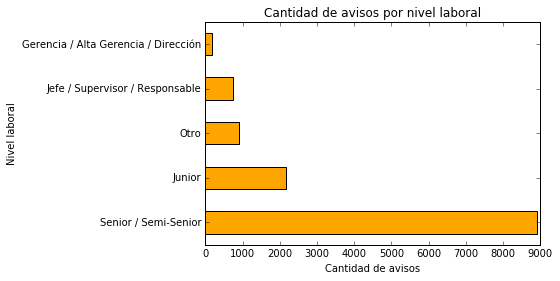

In [103]:
ax = plt.gca()
avisos_detalles.groupby('nivel_laboral')['nivel_laboral'].count().sort_values(ascending=False)\
               .plot(kind='barh', color="orange", title="Cantidad de avisos por nivel laboral");
ax.set_xlabel('Cantidad de avisos')
ax.set_ylabel('Nivel laboral');

#### 2.2.2 Cuales son las areas laborales con mayor cantidad de avisos?


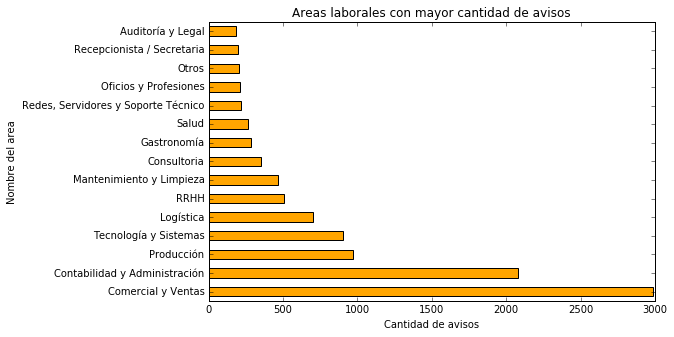

In [104]:
ax = plt.gca()
avisos_detalles.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=False).head(15) \
               .plot(kind='barh', color='orange',figsize=(8,5), title="Areas laborales con mayor cantidad de avisos");
ax.set_xlabel('Cantidad de avisos');
ax.set_ylabel('Nombre del area');

#### 2.2.3 Areas Laborales con Menor Cantidad de Avisos

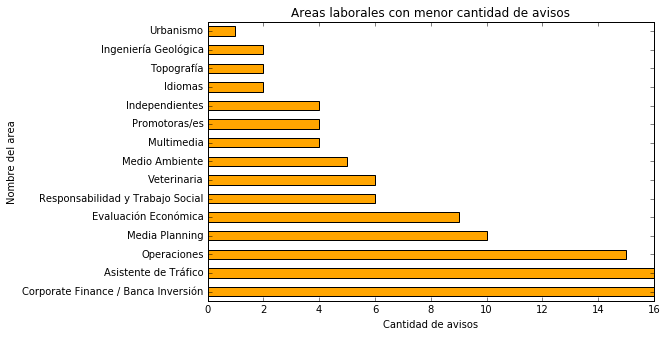

In [105]:
ax = plt.gca()
avisos_detalles.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=True).head(15).sort_values(ascending=False)\
               .plot(kind='barh', figsize=(8,5), color='orange', title='Areas laborales con menor cantidad de avisos');
ax.set_xlabel('Cantidad de avisos');
ax.set_ylabel('Nombre del area');

#### 2.2.4 Cuales son las Areas Laborales con Mayor Cantidad de Postulaciones

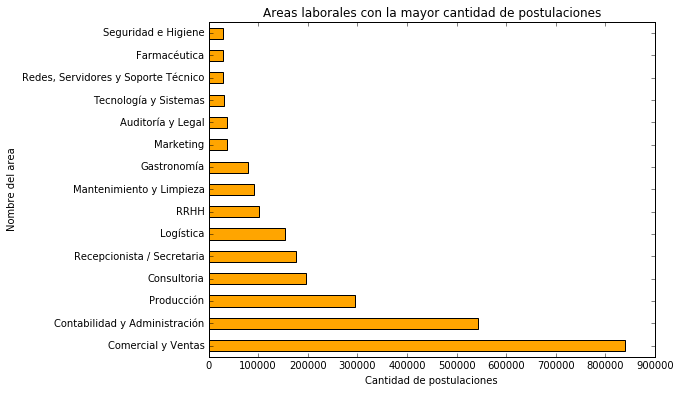

In [106]:
ax = plt.gca()
postulaciones_con_detalle_de_aviso.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=False).head(15)\
                                     .plot(kind='barh', figsize=(8,6), color='orange', title='Areas laborales con la mayor cantidad de postulaciones');
ax.set_xlabel('Cantidad de postulaciones');
ax.set_ylabel('Nombre del area');

#### 2.2.5 Cuales son las Areas Laborales con Menor Cantidad de Postulacione

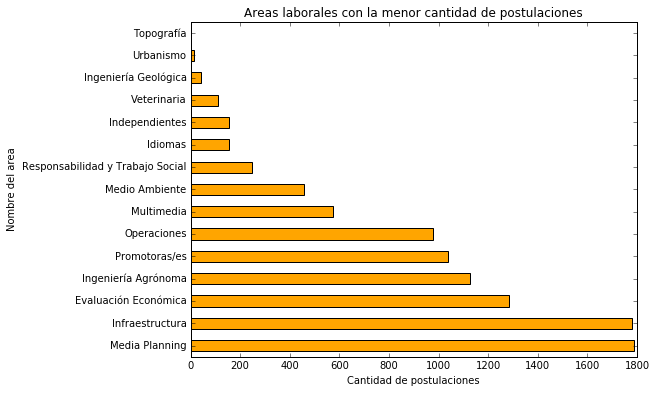

In [107]:
ax = plt.gca()
postulaciones_con_detalle_de_aviso.groupby('nombre_area')['nombre_area'].count().sort_values(ascending=True).head(15).sort_values(ascending=False)\
                                     .plot(kind='barh', figsize=(8,6), color='orange', title='Areas laborales con la menor cantidad de postulaciones');
ax.set_xlabel('Cantidad de postulaciones');
ax.set_ylabel('Nombre del area');

#### 2.2.6. Trabajos más buscados por Estudiantes Universitarios

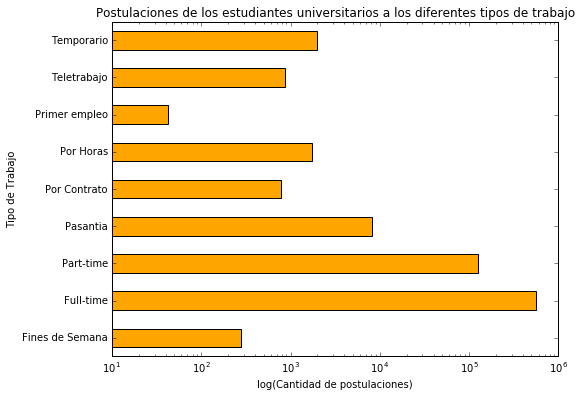

In [108]:
ax = plt.gca()

postulantes_universitarios_estudiantes = postulantes[postulantes['valor_educacion'] == 10]
postulantes_universitarios_estudiantes = pd.merge(postulantes_universitarios_estudiantes, postulaciones, how='inner', on='idpostulante')
postulantes_universitarios_estudiantes = pd.merge(postulantes_universitarios_estudiantes, avisos_detalles, how='inner', on='idaviso')
postulantes_universitarios_estudiantes = postulantes_universitarios_estudiantes.groupby('tipo_de_trabajo')['idpostulante'].count()

postulantes_universitarios_estudiantes.plot(kind='barh', figsize=(8,6), logx=True, ax=ax, color='Orange', \
               title='Postulaciones de los estudiantes universitarios a los diferentes tipos de trabajo');
ax.set_xlabel('log(Cantidad de postulaciones)');
ax.set_ylabel('Tipo de Trabajo');

#### 2.2.7. Trabajos más buscados por Universitarios Graduados

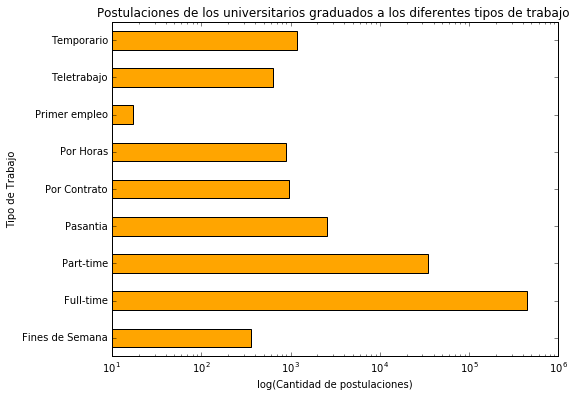

In [109]:
ax = plt.gca()

postulantes_universitarios_graduados = postulantes[postulantes['valor_educacion'] == 12]
postulantes_universitarios_graduados = pd.merge(postulantes_universitarios_graduados, postulaciones, how='inner', on='idpostulante')
postulantes_universitarios_graduados = pd.merge(postulantes_universitarios_graduados, avisos_detalles, how='inner', on='idaviso')
postulantes_universitarios_graduados = postulantes_universitarios_graduados.groupby('tipo_de_trabajo')['idpostulante'].count()

postulantes_universitarios_graduados.plot(kind='barh', figsize=(8,6), logx=True, ax=ax, color='Orange', \
               title='Postulaciones de los universitarios graduados a los diferentes tipos de trabajo ');
ax.set_xlabel('log(Cantidad de postulaciones)');
ax.set_ylabel('Tipo de Trabajo');

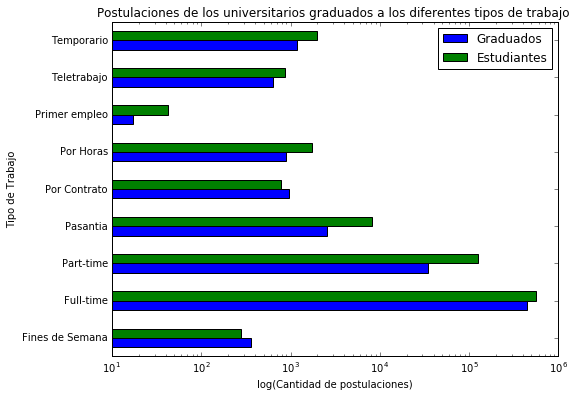

In [110]:
postulantes_universitarios_estudiantes2 = postulantes_universitarios_estudiantes.reset_index()
postulantes_universitarios_graduados2 = postulantes_universitarios_graduados.reset_index()
postulantes_universitarios_estudiantes2.rename({'idpostulante': 'estudiantes'}, axis=1, inplace=True)
postulantes_universitarios_graduados2.rename({'idpostulante': 'graduados'}, axis=1, inplace=True)

postulantes_universitarios_graduados2.set_index('tipo_de_trabajo', inplace=True)
postulantes_universitarios_estudiantes2.set_index('tipo_de_trabajo',inplace=True)
postulantes_universitarios = pd.concat([postulantes_universitarios_graduados2, postulantes_universitarios_estudiantes2], axis=1)
postulantes_universitarios.index.name=None
postulantes_universitarios

ax = plt.gca()
postulantes_universitarios.plot(kind='barh', figsize=(8,6), logx=True, ax=ax, \
               title='Postulaciones de los universitarios graduados a los diferentes tipos de trabajo ');
ax.set_xlabel('log(Cantidad de postulaciones)');
ax.set_ylabel('Tipo de Trabajo')
ax.legend(['Graduados', 'Estudiantes']);

## 3. Análisis de Vistas y Postulaciones por Fecha

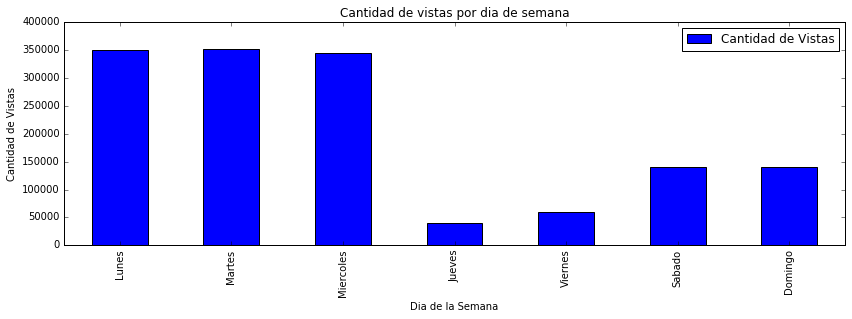

In [111]:
# Cantidad de Vistas por dia de semana

# Se llego a la conclusion de que la cantidad de vistas totales son los registros del 
# archivo vistas + archivo postulaciones

# Tomo la fecha minima de las vistas, para filtrar las postulaciones y asegurarme que tengo los mismos rangos de tiempo
# (ultimos 7 dias) para comparar.
min_vista_fecha = vistas['fechavista'].sort_values().loc[0]

ax = plt.gca()

vistas_weekday = postulaciones[postulaciones["fechapostulacion"] >= min_vista_fecha]
vistas_weekday.rename(columns={"fechapostulacion":"fechavista"}, inplace=True)
vistas_weekday = pd.concat([vistas, vistas_weekday])
vistas_weekday['weekday'] = vistas_weekday['fechavista'].dt.weekday_name
vistas_weekday['dayofweek'] = vistas_weekday['fechavista'].dt.dayofweek
vistas_weekday_groupby = vistas_weekday.groupby(['dayofweek','weekday']).count()['fechavista'].reset_index()
vistas_weekday_groupby.set_index('weekday', inplace=True)
vistas_weekday_groupby.drop('dayofweek', inplace=True, axis=1)
vistas_weekday_groupby.index.name = None
vistas_weekday_groupby.rename({'fechavista': 'Cantidad de Vistas'}, inplace=True, axis=1)

vistas_weekday_groupby.rename({
    'Monday' : 'Lunes',
    'Tuesday' : 'Martes',
    'Wednesday' : 'Miercoles',
    'Thursday' : 'Jueves',
    'Friday' : 'Viernes',
    'Saturday' : 'Sabado',
    'Sunday' : 'Domingo'
}, axis=0, inplace=True)


vistas_weekday_groupby.plot(ax = ax, title = "Cantidad de vistas por dia de semana",kind='bar',figsize=(14,4))
# vistas_weekday_groupby.plot(ax = ax, title = "Cantidad de vistas por dia de semana",kind='line',figsize=(14,4), secondary_y=True)

plt.xlabel('Dia de la Semana')
plt.ylabel('Cantidad de Vistas');

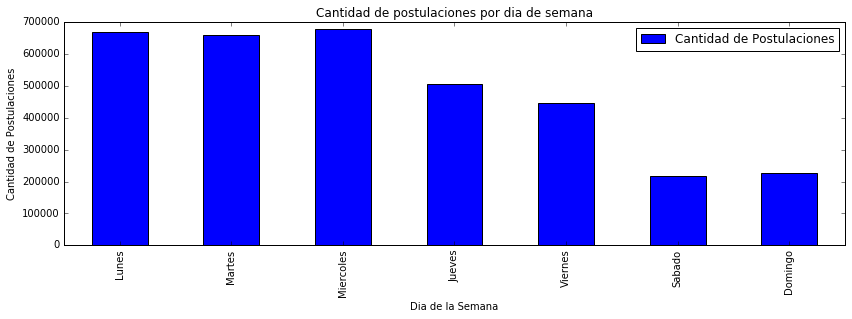

In [112]:
#cantidad de postulaciones por dia de semana
post_weekday = postulaciones
post_weekday['weekday'] =  post_weekday['fechapostulacion'].dt.weekday_name
post_weekday['dayofweek'] =  post_weekday['fechapostulacion'].dt.dayofweek
post_weekday = post_weekday.groupby(['weekday', 'dayofweek']).count()['fechapostulacion'].reset_index()
post_weekday = post_weekday.sort_values('dayofweek', ascending=True).reset_index()
post_weekday.drop(['index', 'dayofweek'], inplace=True, axis=1)
post_weekday.set_index('weekday', inplace=True)
post_weekday.index.name = None

post_weekday.rename({'fechapostulacion': 'Cantidad de Postulaciones' }, axis=1, inplace=True)

post_weekday.rename({
    'Monday' : 'Lunes',
    'Tuesday' : 'Martes',
    'Wednesday' : 'Miercoles',
    'Thursday' : 'Jueves',
    'Friday' : 'Viernes',
    'Saturday' : 'Sabado',
    'Sunday' : 'Domingo'
}, axis=0, inplace=True)

post_weekday.plot(kind='bar', title = "Cantidad de postulaciones por dia de semana",figsize=(14,4));
plt.xlabel('Dia de la Semana')
plt.ylabel('Cantidad de Postulaciones');

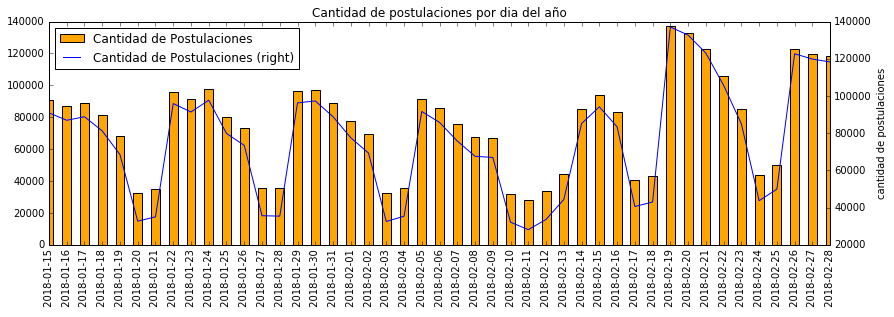

In [113]:
#cantidad de postulaciones por dia de semana
post_weekday = postulaciones
post_weekday['fecha'] = " " + post_weekday['fechapostulacion'].dt.date.astype(str)
post_weekday_groupby = post_weekday.groupby(['fecha']).count()['fechapostulacion'].reset_index()
post_weekday_groupby.rename({'fechapostulacion' : 'cantidad'}, axis=0, inplace=True)
post_weekday_groupby.set_index('fecha', inplace=True)
post_weekday_groupby.index.name = None

post_weekday_groupby.rename({'fechapostulacion': 'Cantidad de Postulaciones' }, axis=1, inplace=True)

ax = plt.gca()

post_weekday_groupby.plot(rot=90, ax = ax, title = "Cantidad de postulaciones por dia del año", kind='bar',figsize=(14,4), color='Orange')
post_weekday_groupby.plot(rot=90, ax = ax, title = "Cantidad de postulaciones por dia del año", kind='line',figsize=(14,4), secondary_y=True)
plt.xlabel('dia de la semana')
plt.ylabel('cantidad de postulaciones');

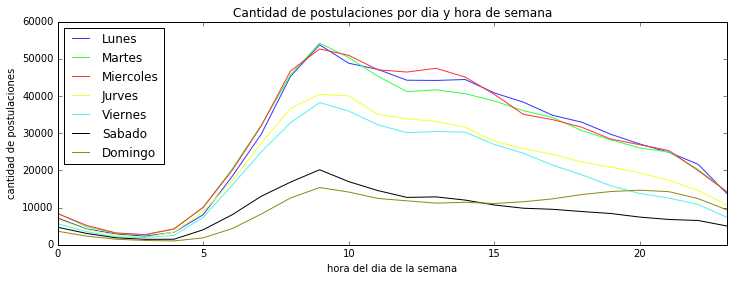

In [114]:
#cantidad de postulaciones por dia y hora de semana
post_weekday_hour = post_weekday
post_weekday_hour['hour'] = post_weekday_hour['fechapostulacion'].dt.hour
post_weekday_hour = post_weekday_hour.loc[:,['idaviso','weekday','hour']]

#separo por dia
post_Monday = post_weekday_hour[post_weekday_hour.weekday == 'Monday']
post_Tuesday = post_weekday_hour[post_weekday_hour.weekday == 'Tuesday']
post_Wednesday = post_weekday_hour[post_weekday_hour.weekday == 'Wednesday']
post_Thursday = post_weekday_hour[post_weekday_hour.weekday == 'Thursday']
post_Friday = post_weekday_hour[post_weekday_hour.weekday == 'Friday']
post_Saturday = post_weekday_hour[post_weekday_hour.weekday == 'Saturday']
post_Sunday = post_weekday_hour[post_weekday_hour.weekday == 'Sunday']

#agrupo por hora por cada dia con la cantidad de postulaciones
post_Monday = post_Monday.groupby('hour', as_index=False)['idaviso'].count()
post_Monday.columns = ['hour', 'Lunes']
post_Tuesday = post_Tuesday.groupby('hour', as_index=False)['idaviso'].count()
post_Tuesday.columns = ['hour', 'Martes']
post_Wednesday = post_Wednesday.groupby('hour', as_index=False)['idaviso'].count()
post_Wednesday.columns = ['hour', 'Miercoles']
post_Thursday = post_Thursday.groupby('hour', as_index=False)['idaviso'].count()
post_Thursday.columns = ['hour', 'Jurves']
post_Friday = post_Friday.groupby('hour', as_index=False)['idaviso'].count()
post_Friday.columns = ['hour', 'Viernes']
post_Saturday = post_Saturday.groupby('hour', as_index=False)['idaviso'].count()
post_Saturday.columns = ['hour', 'Sabado']
post_Sunday = post_Sunday.groupby('hour', as_index=False)['idaviso'].count()
post_Sunday.columns = ['hour', 'Domingo']

#junto los dias
post_weekday_hour = pd.merge(post_Monday, post_Tuesday, on='hour', how="left")
post_weekday_hour = pd.merge(post_weekday_hour, post_Wednesday, on='hour', how="left")
post_weekday_hour = pd.merge(post_weekday_hour, post_Thursday, on='hour', how="left")
post_weekday_hour = pd.merge(post_weekday_hour, post_Friday, on='hour', how="left")
post_weekday_hour = pd.merge(post_weekday_hour, post_Saturday, on='hour', how="left")
post_weekday_hour = pd.merge(post_weekday_hour, post_Sunday, on='hour', how="left")

post_weekday_hour.plot(x='hour', title="Cantidad de postulaciones por dia y hora de semana", figsize=(12,4),
            color=['#3336FF','#33FF49','#FF3333','#F3FF33','#55F1F1','#000000','#93881A'])
plt.xlabel('hora del dia de la semana')
plt.ylabel('cantidad de postulaciones')
plt.show()

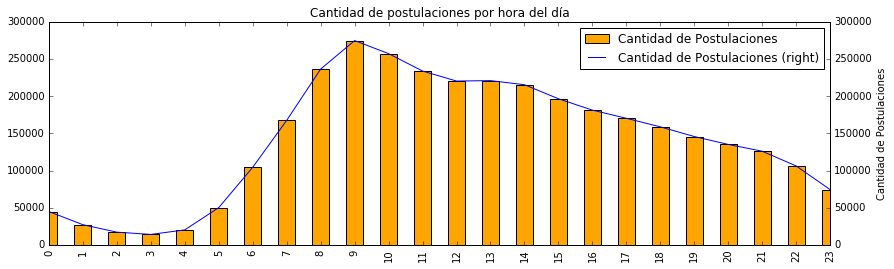

In [115]:
post_byhour = postulaciones
post_byhour['hora'] = post_byhour['fechapostulacion'].dt.hour
post_byhour_groupby = post_byhour.groupby(['hora']).count()['fechapostulacion'].reset_index()
post_byhour_groupby.rename({'fechapostulacion': 'Cantidad de Postulaciones' }, axis=1, inplace=True)

post_byhour_groupby.set_index('hora', inplace=True)
post_byhour_groupby.index.name = None

ax = plt.gca()

post_byhour_groupby.plot(rot=90, ax = ax, title = "Cantidad de postulaciones por hora del día", kind='bar',figsize=(14,4), color='Orange')
post_byhour_groupby.plot(rot=90, ax = ax, title = "Cantidad de postulaciones por hora del día", kind='line',figsize=(14,4), secondary_y=True)
plt.xlabel('Hora del Dia')
plt.ylabel('Cantidad de Postulaciones');

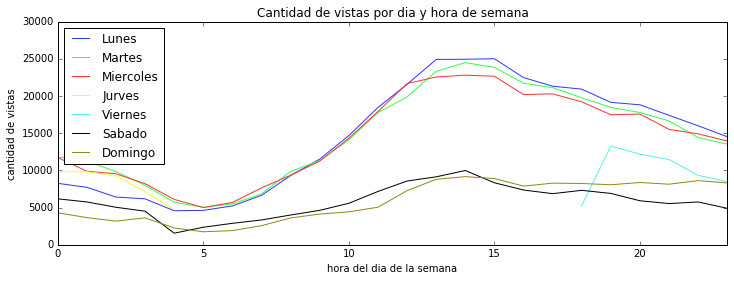

In [116]:
#cantidad de vistas por dia y hora de semana
vistas_weekday_hour = vistas_weekday.copy()
vistas_weekday_hour['hour'] = vistas_weekday_hour['fechavista'].dt.hour
vistas_weekday_hour = vistas_weekday_hour.loc[:,['idaviso','weekday','hour']]

#separo por dia
vistas_Monday = vistas_weekday_hour[vistas_weekday_hour.weekday == 'Monday']
vistas_Tuesday = vistas_weekday_hour[vistas_weekday_hour.weekday == 'Tuesday']
vistas_Wednesday = vistas_weekday_hour[vistas_weekday_hour.weekday == 'Wednesday']
vistas_Thursday = vistas_weekday_hour[vistas_weekday_hour.weekday == 'Thursday']
vistas_Friday = vistas_weekday_hour[vistas_weekday_hour.weekday == 'Friday']
vistas_Saturday = vistas_weekday_hour[vistas_weekday_hour.weekday == 'Saturday']
vistas_Sunday = vistas_weekday_hour[vistas_weekday_hour.weekday == 'Sunday']

#agrupo por hora por cada dia con la cantidad de postulaciones
vistas_Monday = vistas_Monday.groupby('hour', as_index=False)['idaviso'].count()
vistas_Monday.columns = ['hour', 'Lunes']
vistas_Tuesday = vistas_Tuesday.groupby('hour', as_index=False)['idaviso'].count()
vistas_Tuesday.columns = ['hour', 'Martes']
vistas_Wednesday = vistas_Wednesday.groupby('hour', as_index=False)['idaviso'].count()
vistas_Wednesday.columns = ['hour', 'Miercoles']
vistas_Thursday = vistas_Thursday.groupby('hour', as_index=False)['idaviso'].count()
vistas_Thursday.columns = ['hour', 'Jurves']
vistas_Friday = vistas_Friday.groupby('hour', as_index=False)['idaviso'].count()
vistas_Friday.columns = ['hour', 'Viernes']
vistas_Saturday = vistas_Saturday.groupby('hour', as_index=False)['idaviso'].count()
vistas_Saturday.columns = ['hour', 'Sabado']
vistas_Sunday = vistas_Sunday.groupby('hour', as_index=False)['idaviso'].count()
vistas_Sunday.columns = ['hour', 'Domingo']

#junto los dias
vistas_weekday_hour = pd.merge(vistas_Monday, vistas_Tuesday, on='hour', how="left")
vistas_weekday_hour = pd.merge(vistas_weekday_hour, vistas_Wednesday, on='hour', how="left")
vistas_weekday_hour = pd.merge(vistas_weekday_hour, vistas_Thursday, on='hour', how="left")
vistas_weekday_hour = pd.merge(vistas_weekday_hour, vistas_Friday, on='hour', how="left")
vistas_weekday_hour = pd.merge(vistas_weekday_hour, vistas_Saturday, on='hour', how="left")
vistas_weekday_hour = pd.merge(vistas_weekday_hour, vistas_Sunday, on='hour', how="left")

vistas_weekday_hour.plot(x='hour', title="Cantidad de vistas por dia y hora de semana", figsize=(12,4),
            color=['#3336FF','#33FF49','#FF3333','#F3FF33','#55F1F1','#000000','#93881A'])
plt.xlabel('hora del dia de la semana')
plt.ylabel('cantidad de vistas')
plt.show()

In [117]:
div = 1

postulaciones_por_dia = postulaciones.copy()
postulaciones_por_dia['fecha'] = postulaciones_por_dia['fechapostulacion'].dt.date.astype(str) \
    + " - " + (((postulaciones_por_dia['fechapostulacion'].dt.hour) // div) * div).astype(str) + "hs"
postulaciones_por_dia.drop(['idpostulante', 'fechapostulacion'], axis=1, inplace=True)
postulaciones_por_dia = postulaciones_por_dia.groupby('fecha')['idaviso'].count().reset_index()
postulaciones_por_dia.rename(columns={"idaviso":"postulaciones"}, inplace=True)
postulaciones_por_dia.set_index('fecha', inplace=True)
postulaciones_por_dia.index.name = None

vistas_por_dia = vistas.copy()
vistas_por_dia['fecha'] = vistas_por_dia['fechavista'].dt.date.astype(str) \
     + " - " + (((vistas_por_dia['fechavista'].dt.hour) // div) * div).astype(str) + "hs"
vistas_por_dia.drop(['idpostulante', 'fechavista'], axis=1, inplace=True)
vistas_por_dia = vistas_por_dia.groupby('fecha')['idaviso'].count().reset_index()
vistas_por_dia.rename(columns={"idaviso":"vistas"}, inplace=True)
vistas_por_dia.set_index('fecha', inplace=True)
vistas_por_dia.index.name = None

In [118]:
interacciones_por_dia = pd.concat([postulaciones_por_dia, vistas_por_dia], axis=1)
interacciones_por_dia.dropna(inplace=True)
interacciones_por_dia['vistas'] = interacciones_por_dia['vistas'] + interacciones_por_dia['postulaciones'] 

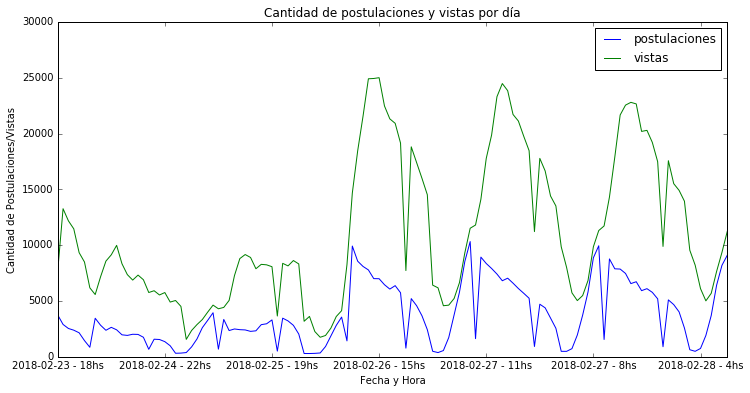

In [119]:
ax = plt.gca()
interacciones_por_dia.plot(ax=ax, title = "Cantidad de postulaciones y vistas por día", kind='line', figsize=(12,6))
plt.xlabel('Fecha y Hora');
plt.ylabel('Cantidad de Postulaciones/Vistas')

## 4. Análisis de Postulaciones según nivel educativo

### 4.1. Análisis de Postulaciones de Postulantes con Educación Secundaria

In [120]:
postulantes_sec = postulantes.loc[postulantes['valor_educacion'] == 5].reset_index()
postulantes_sec.drop('index',inplace=True, axis=1)
postulantes_sec = postulantes_sec[(postulantes_sec['edad'] >= 18) & (postulantes_sec['edad'] <= 65)]

# Obtengo las decadas correspondientes para agrupar
postulantes_sec['decil'] = postulantes_sec['edad'].apply(lambda x: (x // 10) * 10)
postulantes_sec.head()

,idpostulante,valor_educacion,fechanacimiento,sexo,edad,decil
0,0zBJ0pM,5,1991-01-21,FEM,27.0,20.0
1,0zBKV68,5,1997-12-14,FEM,20.0,20.0
2,0zBM0Ka,5,1995-07-14,FEM,22.0,20.0
3,0zBO4Vv,5,1985-06-20,MASC,32.0,30.0
4,0zBYY29,5,1994-11-10,MASC,23.0,20.0


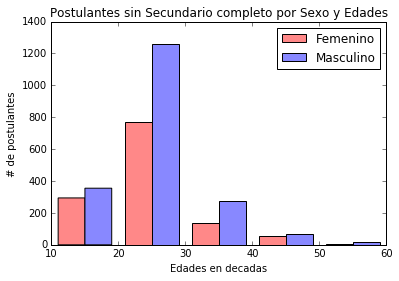

In [121]:
#diferencio entre mujeres y hombres
sec_fem = postulantes_sec.loc[postulantes_sec['sexo'] == 'FEM']
sec_masc = postulantes_sec.loc[postulantes_sec['sexo'] == 'MASC']
plt.xlabel('Edades en decadas')
plt.ylabel('# de postulantes')
plt.title('Postulantes sin Secundario completo por Sexo y Edades')
plt.hist([sec_fem['decil'],sec_masc['decil']], bins=5, color=['#FF8888', '#8888FF'], label=['Femenino','Masculino'])
plt.legend()
plt.show()

In [122]:
#veo las postulaciones que han hecho los que no poseen secundario completo
#ejemplo usado https://plot.ly/pandas/bubble-charts/
mergeo_sec = pd.merge(postulantes_sec, postulaciones)
agrup_sec = mergeo_sec.groupby(['idaviso']).size().to_frame(name='count').reset_index()
secs = pd.merge(avisos_detalles, agrup_sec, on='idaviso')
secs.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
#secs.sort_values(by='count',ascending=False)
secs_emp = secs[secs['count'] > 100]
secs_emp.sort_values(by='count',ascending=True)
secs_emp.iplot(kind='bubble', size='count', text='count', y='nombre_area', x='denominacion_empresa', mode='markers',
color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)', 'rgb(44, 160, 101)', 'rgb(255, 65, 54)'], 
     opacity=[1, 0.8, 0.6, 0.4],filename='simple-bubble-chart',title='Postulaciones Secundario Incompleto')

# Por ello suponemos que una persona con secundario en curso se postula principalmente 
# en mantenimiento y limpieza, ventas y en menor medida en produccion.

In [123]:
sec_vistas = pd.merge(postulantes_sec, vistas)
# sec_vistas = sec_vistas.rename(columns={"idAviso": "idaviso"})
secus_views = sec_vistas.groupby(['idaviso']).size().to_frame(name='count_vistas').reset_index()
secus_views_avisos = pd.merge(avisos_detalles, secus_views)
secus_views_avisos.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
sec_max = secus_views_avisos[secus_views_avisos['count_vistas'] > 40]
sec_max.sort_values(by='count_vistas', ascending=True, inplace=True)
sec_max = sec_max.reset_index()
sec_max.iplot(kind='bubble', size='count_vistas', text='count_vistas', y='nivel_laboral', x='nombre_area', filename='simple-bubble-chart', title='Vistas postulantes Secundario Incompleto')

#### En este ejemplo visualizamos que las vistas corresponden mayormente a Mantenimiento y Limpieza siguiendo muy de lejos el rubro ventas.

### 4.2. Análisis de Postulaciones según todos los niveles educativos.

In [124]:
post_all = pd.merge(postulaciones, postulantes)
total_post = post_all.groupby(['idaviso']).size().to_frame(name='count_post').reset_index()
total_views_avisos = pd.merge(avisos_detalles, total_post)
total_views_avisos.drop(['mapacalle','titulo','ciudad','nombre_zona','descripcion'],1,inplace=True)
total_views_avisos_min = total_views_avisos[total_views_avisos['count_post'] > 500]
total_views_avisos_min.iplot(kind='bubble', size='count_post', text='count_post', y='nivel_laboral', \
                             x='nombre_area', filename='simple-bubble-chart', \
                             title='Postulaciones totales por area y nivel laboral')

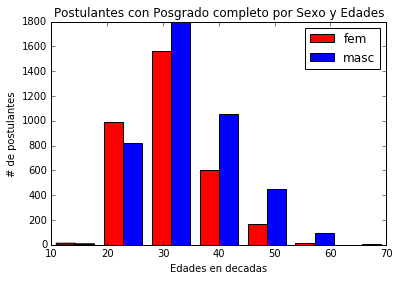

In [125]:
postulantes_postgrado = postulantes[postulantes.valor_educacion > 15]
postulantes_postgrado['decil'] = np.floor( postulantes_postgrado['edad'].apply(lambda x: x /10) )
postulantes_postgrado['decil'] = postulantes_postgrado['decil'].apply(lambda x: x*10)
post_fem = postulantes_postgrado.loc[postulantes_postgrado['sexo'] == 'FEM']
post_masc = postulantes_postgrado.loc[postulantes_postgrado['sexo'] == 'MASC']
plt.xlabel('Edades en decadas')
plt.ylabel('# de postulantes')
plt.title('Postulantes con Posgrado completo por Sexo y Edades')
plt.hist([post_fem['decil'].dropna(),post_masc['decil'].dropna()], bins=7, color=['red', 'blue'], label=['fem','masc'])
plt.legend()
plt.show()

#### Encontramos bastante curioso que menores de 20 años tengan posgrado en curso, o master, etc.

## 5. Postulaciones y Vistas por Género

### 5.1. Proporción de avisos que Especifican Género

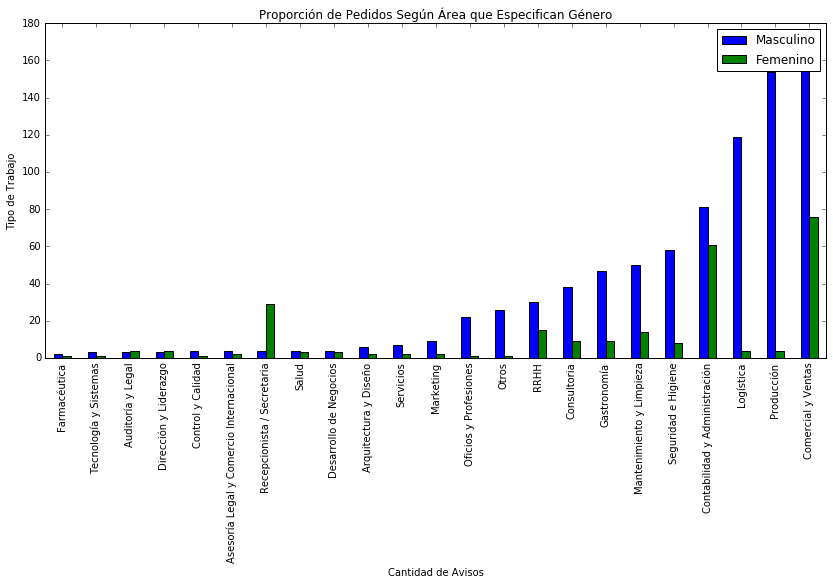

In [126]:
# Mediante una regular expression, extraemos del aviso la información de si 
# se está buscando un género en particular para una posición.
avisos_detalles['sexo'] = avisos_detalles.descripcion.str.lower().str.extract(r'(masculino|hombre|femenino|mujer)')
avisos_detalles['sexo'] = avisos_detalles['sexo'].str.replace('mujer', 'FEM')
avisos_detalles['sexo'] = avisos_detalles['sexo'].str.replace('hombre', 'MASC')
avisos_detalles['sexo'] = avisos_detalles['sexo'].str.replace('femenino', 'FEM')
avisos_detalles['sexo'] = avisos_detalles['sexo'].str.replace('masculino', 'MASC')
df = pd.DataFrame(avisos_detalles.groupby(['nombre_area', 'sexo'])['idaviso'].count())
df = df.dropna()
df.reset_index(inplace=True)
 
df_fem = df.loc[df['sexo'] == 'FEM']
df_masc = df.loc[df['sexo'] == 'MASC']

df_fem.rename({'idaviso': 'cantidad_fem'}, axis=1, inplace=True)
df_masc.rename({'idaviso': 'cantidad_masc'}, axis=1, inplace=True)

df_fem.drop('sexo', inplace=True, axis=1)
df_masc.drop('sexo', inplace=True, axis=1)

df = pd.merge(df_masc, df_fem, on='nombre_area', how='inner')
df['proporcion_masc_fem'] = df['cantidad_masc'] / df['cantidad_fem']
df.sort_values('proporcion_masc_fem', inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

##########################

df.drop('proporcion_masc_fem', inplace=True, axis=1)
df.sort_values('cantidad_masc', inplace=True)
df.set_index('nombre_area', inplace=True)

ax = plt.gca()
df.plot(kind='bar', figsize=(14,6), ax=ax, \
               title='Proporción de Pedidos Según Área que Especifican Género');
ax.set_xlabel('Cantidad de Avisos');
ax.set_ylabel('Tipo de Trabajo')
ax.legend(['Masculino', 'Femenino']);

### 5.2. Proporción de Postulantes que se Postulan a Posiciones que Exigen Distinto Género

In [127]:
avisos_detalles_por_sexo = avisos_detalles[avisos_detalles['sexo'].notnull()]
avisos_detalles_por_sexo = pd.merge(avisos_detalles_por_sexo, postulaciones, on='idaviso', how='inner')
avisos_detalles_por_sexo = pd.merge(avisos_detalles_por_sexo, postulantes, on='idpostulante', how='inner')
avisos_detalles_por_sexo.drop(['titulo', 'descripcion', 'ciudad', 'mapacalle', 'denominacion_empresa',\
                              'fechapostulacion', 'weekday', 'dayofweek', 'hora', 'valor_educacion', \
                              'fechanacimiento'], inplace=True, axis=1)
avisos_detalles_por_sexo = avisos_detalles_por_sexo[avisos_detalles_por_sexo['sexo_x'] != avisos_detalles_por_sexo['sexo_y']]
avisos_detalles_por_sexo = avisos_detalles_por_sexo[avisos_detalles_por_sexo['sexo_y'] != 'NO_DECLARA']
avisos_detalles_por_sexo.reset_index(inplace=True)
avisos_detalles_por_sexo.sort_values('edad', inplace=True)
avisos_detalles_por_sexo = avisos_detalles_por_sexo[avisos_detalles_por_sexo['edad'].notnull()]

avisos_detalles_por_sexo.groupby('sexo_y')['idaviso'].count()
# Hay muchas mujeres que se postulan a posiciones que especifican "masculino", y menos hombres que se postulan a posiciones
# que especifican "femenino", pero también, hay muchos más avisos que especifican "masculino".

sexo_y
FEM           34044
MASC          12681
NO_DECLARA        0
Name: idaviso, dtype: int64

### 5.3. Distribución de postulaciones según Género y Área

In [128]:
postulaciones_count = pd.merge(postulaciones, post_gen_edad, how='inner', on='idpostulante')
postulaciones_count = pd.merge(postulaciones_count, avisos_detalles, how='inner', on='idaviso')
postulaciones_count.drop(['idaviso', 'idpostulante', 'fechapostulacion', 'fechanacimiento', 'titulo', \
                          'descripcion', 'mapacalle', 'ciudad', 'denominacion_empresa'], inplace=True, axis=1)
postulaciones_count['edad_masc'] = np.where(postulaciones_count['sexo_x'] == 'MASC', postulaciones_count['edad'], np.NaN)
postulaciones_count['edad_fem'] = np.where(postulaciones_count['sexo_x'] == 'FEM', postulaciones_count['edad'], np.NaN)
postulaciones_count = postulaciones_count[postulaciones_count['edad'] <= 75]

In [129]:
postulaciones_count_sex = postulaciones_count[['nombre_area', 'sexo_x']].reset_index()
postulaciones_count_fem = postulaciones_count_sex[postulaciones_count_sex['sexo_x'] == 'FEM']
postulaciones_count_masc = postulaciones_count_sex[postulaciones_count_sex['sexo_x'] == 'MASC']

In [130]:
# Busco las áreas con más postulaciones de masculinos.
postulaciones_count_masc = pd.DataFrame(postulaciones_count_masc.groupby('nombre_area')['index'].count().reset_index())
postulaciones_count_masc = postulaciones_count_masc.sort_values('index', ascending=False)
postulaciones_count_masc.head()

,nombre_area,index
7,Comercial y Ventas,346145
44,Producción,239261
11,Contabilidad y Administración,232062
31,Logística,128669
10,Consultoria,73374


In [131]:
# Busco las áreas con más postulaciones de femeninos.
postulaciones_count_fem = pd.DataFrame(postulaciones_count_fem.groupby('nombre_area')['index'].count().reset_index())
postulaciones_count_fem = postulaciones_count_fem.sort_values('index', ascending=False)
postulaciones_count_fem.head()

,nombre_area,index
7,Comercial y Ventas,480866
11,Contabilidad y Administración,304461
48,Recepcionista / Secretaria,162719
10,Consultoria,121176
47,RRHH,65485


In [132]:
# Creo un nuevo DataFrame de los postulantes.
postulantes_areas = pd.merge(postulaciones, avisos_detalles, how='inner', on='idaviso')
postulantes_areas = pd.DataFrame(postulantes_areas.groupby(['idpostulante', 'nombre_area'])['idaviso'].count()).reset_index()
postulantes_areas = pd.DataFrame(postulantes_areas.sort_values(['idpostulante','idaviso'], ascending=False))#.reset_index()
postulantes_areas = postulantes_areas.groupby(['idpostulante']).first()
postulantes_areas.drop('idaviso', inplace=True, axis=1)
postulantes_areas = postulantes_areas.reset_index()

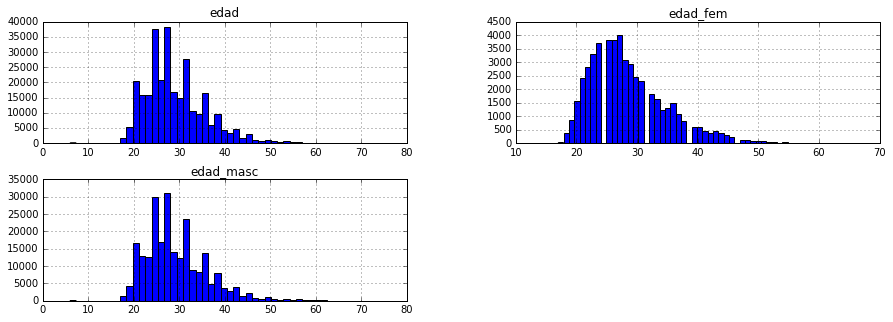

In [133]:
# Tomando dos áreas antagónicas con respecto a la proporción de hombres y mujeres que se postulan. Podemos ver que
# las distribuciones de las edades pueden gráficamente indicar si se trata de un área meramente masculina como Producción,
# o una sumamente femenina como "Recepcionista / Secretaria".

postulaciones_count_graph = postulaciones_count[postulaciones_count['nombre_area'] == 'Producción']
postulaciones_count_graph = pd.DataFrame(postulaciones_count_graph[['edad_masc', 'edad_fem', 'edad']]).reset_index()
postulaciones_count_graph.drop('index', axis=1, inplace=True)
postulaciones_count_graph.hist(bins = 50, alpha=1, stacked=True, figsize=(15, 5))
plt.show()

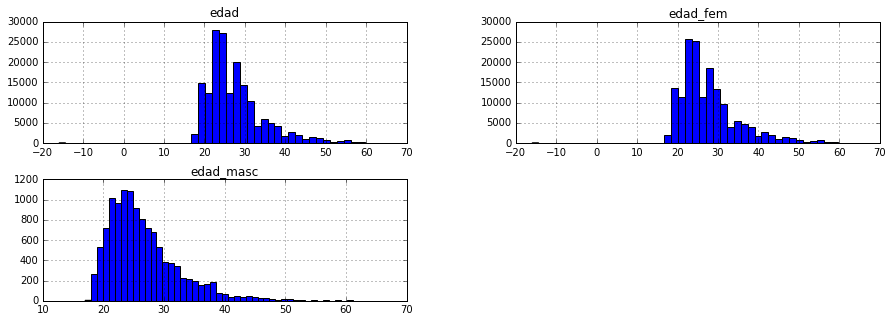

In [134]:
postulaciones_count_graph = postulaciones_count[postulaciones_count['nombre_area'] == 'Recepcionista / Secretaria']
postulaciones_count_graph = pd.DataFrame(postulaciones_count_graph[['edad_masc', 'edad_fem', 'edad']]).reset_index()
postulaciones_count_graph.drop('index', axis=1, inplace=True)
postulaciones_count_graph.hist(bins = 50, alpha=1, stacked=True, figsize=(15, 5))
plt.show()

## 6. Popularidad de los Avisos

### 6.1. Buscamos los Avisos más Populares en base a la Cantidad de Postulaciones en la Menor Cantidad de Días

In [185]:
# Busco cuales son los avisos mas populares, basandome en la cantidad de postulaciones sobre la cantidad de dias que lleva online.
avisos_popularidad = postulaciones.groupby(['idaviso'])['fechapostulacion'].agg(['min', 'max', 'count']).reset_index()
avisos_popularidad['cantidad_dias'] = (avisos_popularidad['max'] - \
                                       avisos_popularidad['min']).apply(lambda x: x.days).astype(int) + 1
avisos_popularidad.drop(['min', 'max'], axis=1, inplace=True)

avisos_popularidad['popularidad_en_postulaciones'] = avisos_popularidad['count'] / avisos_popularidad['cantidad_dias']
avisos_popularidad.drop(['count'], axis=1, inplace=True)
avisos_popularidad.sort_values('popularidad_en_postulaciones', ascending=False, inplace=True)

# Le calculo la probabilidad y lo agrego a la tabla de avisos_detalles.
avisos_detalles_con_popularidad = pd.merge(avisos_detalles, avisos_popularidad, how='inner', \
                          left_on='idaviso', right_on='idaviso')
avisos_detalles_con_popularidad = avisos_detalles_con_popularidad.sort_values('popularidad_en_postulaciones', ascending=False)


In [209]:
#me quedo con los 100 mas populares
avisos_populares = avisos_detalles_con_popularidad.head(100).copy()

In [210]:
#limpio de tags o palabras que no sirven
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' de ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' el ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' la ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' en ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' para ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' y ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<span>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' text ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' decoration ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' lang ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' que ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' por ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</span>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' con ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' un ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<span>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</span>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<p>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</p>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<em>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</em>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<br />',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<strong>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</strong>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<span lang="ES" style="">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<p style="">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<span style="">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<p align="center">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<span style="text-decoration: underline;">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<li>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</li>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<ul>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</ul>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' una ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' los ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' del ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' su ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' al ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' a ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' las ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Si ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' te ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' o ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' es ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' La ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' El ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Entre ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Nos ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Su ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Los ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' sobre ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' En ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' tus ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' tu ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' para ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' se ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('Las ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Se ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(',para ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' EN ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' es ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' sus ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Son ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Es ',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<span lang="ES">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<u style="">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<u>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</u>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<strong style="">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<p align="center" style="">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<li style="">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<div>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</div>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<ol>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('</ol>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<blockquote style="">',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('<blockquote>',' ')
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('Requisito ',' ',case=False)
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Requisito ',' ',case=False)
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' requisito ',' ',case=False)
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Requisitos ',' ',case=False)
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' DE ',' ',case=False)
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' excluyente ',' ',case=False)
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' excluyente',' ',case=False)
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace('excluyente ',' ',case=False)
avisos_populares['descripcion'] = avisos_populares['descripcion'].str.replace(' Excluyente ',' ',case=False)

In [211]:
avisos_populares.drop(['ciudad','mapacalle','nivel_laboral'],axis=1,inplace=True)

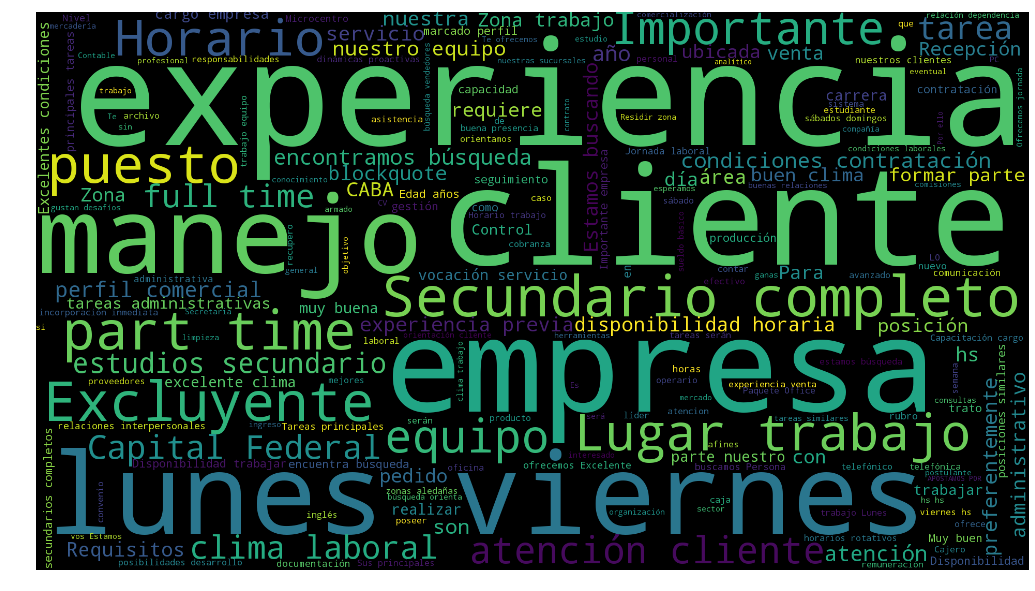

In [212]:
wordcloud_aviso_pop = WordCloud(width=1920, height=1080, margin=0).generate(' '.join(avisos_populares['descripcion']))
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud_aviso_pop)
plt.axis("off")
plt.show()

### 6.2. Buscamos los Avisos con más Cantidad de Postulaciones global

In [188]:
#Obtengo los avisos con el contador de postulantes
aviso_grup =postulaciones.groupby('idaviso')['idpostulante'].count().reset_index()
aviso_grup.rename(columns={'idpostulante':'cant_postulaciones'},inplace=True)
aviso_grup.sort_values(by='cant_postulaciones',ascending=False,inplace=True)
aviso_grup = pd.merge(aviso_grup, avisos_detalles, on='idaviso')

In [189]:
avisos_max_postulantes = aviso_grup.head(50).copy()


In [190]:
#quito palabras a mi parecer innecesarias
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' de ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' el ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' la ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' en ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' para ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' y ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<span>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' text ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' decoration ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' lang ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' que ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' por ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('</span>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' con ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' un ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<span>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('</span>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<p>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('</p>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<em>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('</em>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<br />',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<strong>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('</strong>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<span lang="ES" style="">',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<p style="">',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<span style="">',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<p align="center">',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<span style="text-decoration: underline;">',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<li>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('</li>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<ul>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('</ul>',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' una ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' los ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' del ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' su ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' al ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' a ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' las ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' Si ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' te ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' o ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' es ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' La ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' El ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' Entre ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' Nos ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' Su ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' Los ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' sobre ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' En ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' tus ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' tu ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' para ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' se ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('Las ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' Se ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(',para ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' EN ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' es ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' sus ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' Son ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace(' Es ',' ')
avisos_max_postulantes['descripcion'] = avisos_max_postulantes['descripcion'].str.replace('<span lang="ES">',' ')

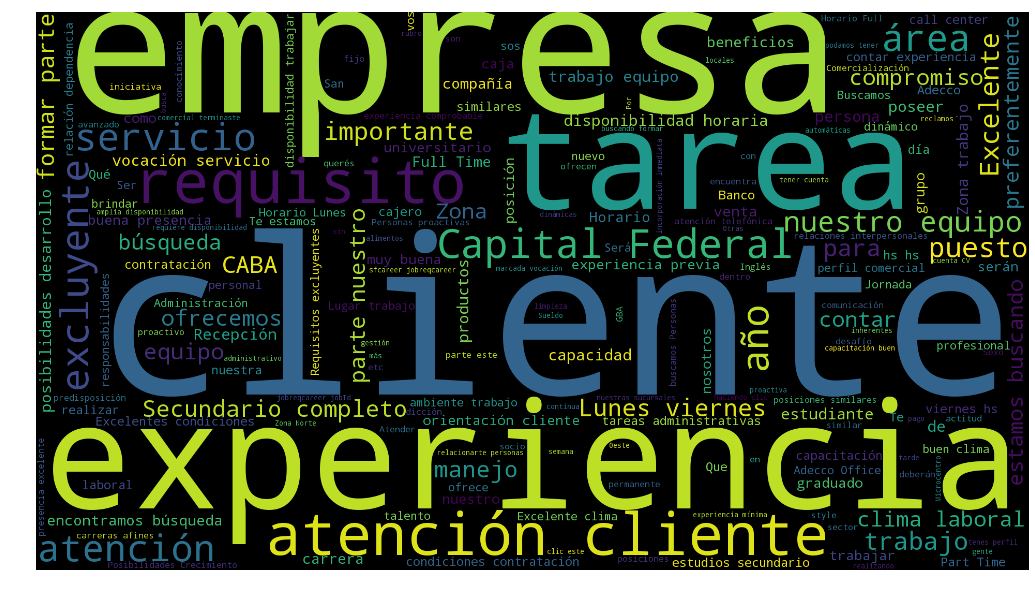

In [191]:
avisos_max_post = WordCloud(width=1920, height=1080, margin=0).generate(' '.join(avisos_max_postulantes['descripcion']))
plt.figure( figsize=(20,10) )
plt.imshow(avisos_max_post)
plt.axis("off")
plt.show()

# 7. Probabilidad de Postulacion Relacionada a la Cantidad de Vistas

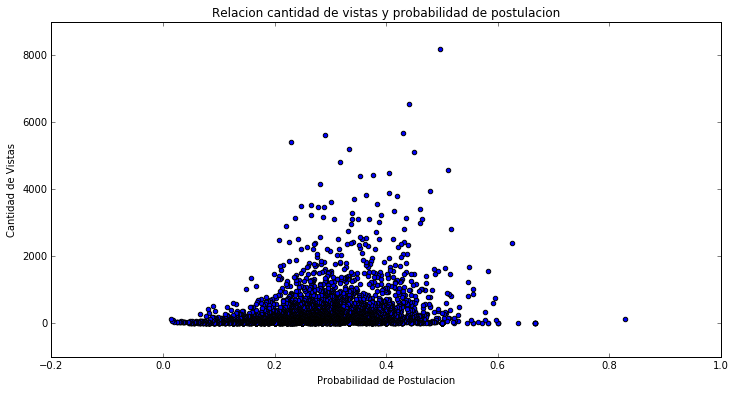

In [136]:
# Cantidad de vistas relacionada con la probabilidad de postulacion
vistas_total = vistas.groupby('idaviso')['idpostulante'].count().reset_index()
vistas_total.rename({'idpostulante' : 'cantidad_vistas'}, inplace=True, axis = 1)
vistas_total.set_index('idaviso', inplace=True)
vistas_total.index.name = None

min_vista_fecha = vistas['fechavista'].sort_values().loc[0]

post_total =  postulaciones[postulaciones["fechapostulacion"] >= min_vista_fecha].groupby('idaviso')['idpostulante'].count().reset_index()
post_total.rename({'idpostulante' : 'cantidad_post'}, inplace=True, axis = 1)
post_total.set_index('idaviso', inplace=True)
post_total.index.name = None

interacciones_total = pd.concat([post_total, vistas_total], axis=1)
interacciones_total.dropna()
interacciones_total['cantidad_vistas'] = interacciones_total['cantidad_vistas'] + interacciones_total['cantidad_post']
interacciones_total['probabilidad_de_postulacion'] = interacciones_total['cantidad_post'] / interacciones_total['cantidad_vistas']
interacciones_total.sort_values('probabilidad_de_postulacion', ascending=False, inplace=True)
# interacciones_total.head(20)
interacciones_total.plot.scatter('probabilidad_de_postulacion','cantidad_vistas',alpha=1,title = "Relacion cantidad de vistas y probabilidad de postulacion",figsize=(12,6));
plt.xlabel('Probabilidad de Postulacion')
plt.ylabel('Cantidad de Vistas')
plt.show()

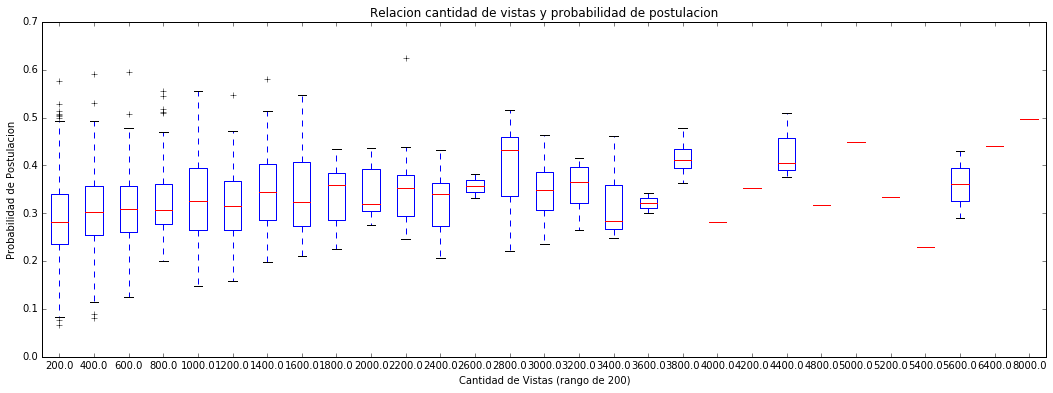

In [137]:
interacciones_total_box = interacciones_total.copy()
interacciones_total_box['cant_vistas_rg'] = np.floor( interacciones_total_box['cantidad_vistas'].apply(lambda x: x/200) )
interacciones_total_box['cant_vistas_rg'] = interacciones_total_box['cant_vistas_rg'].apply(lambda x: x*200)
interacciones_total_box = interacciones_total_box[interacciones_total_box['cant_vistas_rg'] > 100]
interacciones_total_box = interacciones_total_box.loc[:,['cant_vistas_rg','probabilidad_de_postulacion']]
interacciones_total_box['subindex'] = interacciones_total_box.groupby('cant_vistas_rg').cumcount() + 1
interacciones_total_box = pd.pivot_table(interacciones_total_box,index='subindex',columns='cant_vistas_rg',values='probabilidad_de_postulacion')
interacciones_total_box.plot.box(title = "Relacion cantidad de vistas y probabilidad de postulacion", figsize=(18,6));
plt.xlabel('Cantidad de Vistas (rango de 200)')
plt.ylabel('Probabilidad de Postulacion')
plt.show()